**ANGEL METANOSA AFINDA (NIM: 2301212013)**

## **Setup Apache for Spark**

In [ ]:
!pip install pyspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# install java
!apt-get install openjdk-8-jdk-headless -qq > /dev/null

# install spark (change the version number if needed)
!wget -q https://archive.apache.org/dist/spark/spark-3.0.0/spark-3.0.0-bin-hadoop3.2.tgz

# unzip the spark file to the current folder
!tar xf spark-3.0.0-bin-hadoop3.2.tgz

# set your spark folder to your system path environment. 
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.0.0-bin-hadoop3.2"


# install findspark using pip
!pip install -q findspark

In [ ]:
import findspark
findspark.init()

In [ ]:
from pyspark.sql import SparkSession

spark = SparkSession.builder\
        .master("local")\
        .appName("Colab")\
        .config('spark.ui.port', '4050')\
        .getOrCreate()

# **Import Library**

In [ ]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt  # Untuk visualisasi
import seaborn as sns                 # Untuk visualisasi
plt.style.use("seaborn")

from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator

# **Import and Load Dataset**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df_super = spark.read.csv("/content/drive/MyDrive/Magister Informatika/Big Data Analysis/Assesment 3/50_SupermarketBranches.csv", header=True, inferSchema=True)
df_ads = spark.read.csv("/content/drive/MyDrive/Magister Informatika/Big Data Analysis/Assesment 3/Ads_CTR_Optimisation.csv", header=True, inferSchema=True)
df_marketbasket = spark.read.csv("/content/drive/MyDrive/Magister Informatika/Big Data Analysis/Assesment 3/Market_Basket_Optimisation.csv").toDF("col1","col2","col3", "col4","col5","col6", "col7","col8","col9", "col10","col11","col12", "col13","col14","col15", "col16","col17","col18", "col19","col20")
df_custmember = spark.read.csv("/content/drive/MyDrive/Magister Informatika/Big Data Analysis/Assesment 3/Supermarket_CustomerMembers.csv", header=True, inferSchema=True)

# **Data Exploration**

## Supermarket Branches

In [ ]:
df_super.printSchema()

root
 |-- Advertisement Spend: double (nullable = true)
 |-- Promotion Spend: double (nullable = true)
 |-- Administration Spend: double (nullable = true)
 |-- State: string (nullable = true)
 |-- Profit: double (nullable = true)



In [ ]:
df_super.show(2,False)

+-------------------+---------------+--------------------+----------+---------+
|Advertisement Spend|Promotion Spend|Administration Spend|State     |Profit   |
+-------------------+---------------+--------------------+----------+---------+
|165349.2           |136897.8       |471784.1            |New York  |192261.83|
|162597.7           |151377.59      |443898.53           |California|191792.06|
+-------------------+---------------+--------------------+----------+---------+
only showing top 2 rows



In [ ]:
df_supermarket = df_super.withColumnRenamed("Advertisement Spend","AdvertisementSpend") \
    .withColumnRenamed("Promotion Spend","PromotionSpend") \
    .withColumnRenamed("Administration Spend","AdministrationSpend")


df_supermarket.printSchema()

root
 |-- AdvertisementSpend: double (nullable = true)
 |-- PromotionSpend: double (nullable = true)
 |-- AdministrationSpend: double (nullable = true)
 |-- State: string (nullable = true)
 |-- Profit: double (nullable = true)



In [ ]:
df_supermarket.show(2,False)

+------------------+--------------+-------------------+----------+---------+
|AdvertisementSpend|PromotionSpend|AdministrationSpend|State     |Profit   |
+------------------+--------------+-------------------+----------+---------+
|165349.2          |136897.8      |471784.1           |New York  |192261.83|
|162597.7          |151377.59     |443898.53          |California|191792.06|
+------------------+--------------+-------------------+----------+---------+
only showing top 2 rows



In [ ]:
df_branches = df_supermarket.withColumn('TotalSpending', df_supermarket.AdvertisementSpend + df_supermarket.PromotionSpend + df_supermarket.AdministrationSpend)

In [ ]:
df_branches.show()

+------------------+--------------+-------------------+----------+---------+------------------+
|AdvertisementSpend|PromotionSpend|AdministrationSpend|     State|   Profit|     TotalSpending|
+------------------+--------------+-------------------+----------+---------+------------------+
|          165349.2|      136897.8|           471784.1|  New York|192261.83|          774031.1|
|          162597.7|     151377.59|          443898.53|California|191792.06| 757873.8200000001|
|         153441.51|     101145.55|          407934.54|   Florida|191050.39|          662521.6|
|         144372.41|     118671.85|          383199.62|  New York|182901.99|         646243.88|
|         142107.34|      91391.77|          366168.42|   Florida|166187.94|         599667.53|
|          131876.9|      99814.71|          362861.36|  New York|156991.12|         594552.97|
|         134615.46|     147198.87|          127716.82|California|156122.51|409531.14999999997|
|         130298.13|     145530.06|     

In [ ]:
df_supermarket.show

<bound method DataFrame.show of DataFrame[AdvertisementSpend: double, PromotionSpend: double, AdministrationSpend: double, State: string, Profit: double]>

In [ ]:
print((df_supermarket.count(), len(df_supermarket.columns)))

(50, 5)


In [ ]:
print("Jumlah data sebelum drop null:", df_supermarket.count())
df_supermarket = df_supermarket.na.drop("any")
print("Jumlah data setelah drop null : ",df_supermarket.count())

Jumlah data sebelum drop null: 50
Jumlah data setelah drop null :  50


In [ ]:
df_super_pandas = df_supermarket.toPandas()

In [ ]:
df_super_pandas['State'].value_counts()

New York      17
California    17
Florida       16
Name: State, dtype: int64

## Ads_CTR_Optimisation

In [ ]:
df_ads.printSchema()

root
 |-- Ad 1: integer (nullable = true)
 |-- Ad 2: integer (nullable = true)
 |-- Ad 3: integer (nullable = true)
 |-- Ad 4: integer (nullable = true)
 |-- Ad 5: integer (nullable = true)
 |-- Ad 6: integer (nullable = true)
 |-- Ad 7: integer (nullable = true)
 |-- Ad 8: integer (nullable = true)
 |-- Ad 9: integer (nullable = true)
 |-- Ad 10: integer (nullable = true)



In [ ]:
df_ads.show(2,False)

+----+----+----+----+----+----+----+----+----+-----+
|Ad 1|Ad 2|Ad 3|Ad 4|Ad 5|Ad 6|Ad 7|Ad 8|Ad 9|Ad 10|
+----+----+----+----+----+----+----+----+----+-----+
|1   |0   |0   |0   |1   |0   |0   |0   |1   |0    |
|0   |0   |0   |0   |0   |0   |0   |0   |1   |0    |
+----+----+----+----+----+----+----+----+----+-----+
only showing top 2 rows



In [ ]:
print((df_ads.count(), len(df_ads.columns)))

(10000, 10)


In [ ]:
print("Jumlah data sebelum drop null:", df_ads.count())
df_ads = df_ads.na.drop("any")
print("Jumlah data setelah drop null : ",df_ads.count())

Jumlah data sebelum drop null: 10000
Jumlah data setelah drop null :  10000


## **Market Basket Optimization**

In [ ]:
df_marketbasket.printSchema()

root
 |-- col1: string (nullable = true)
 |-- col2: string (nullable = true)
 |-- col3: string (nullable = true)
 |-- col4: string (nullable = true)
 |-- col5: string (nullable = true)
 |-- col6: string (nullable = true)
 |-- col7: string (nullable = true)
 |-- col8: string (nullable = true)
 |-- col9: string (nullable = true)
 |-- col10: string (nullable = true)
 |-- col11: string (nullable = true)
 |-- col12: string (nullable = true)
 |-- col13: string (nullable = true)
 |-- col14: string (nullable = true)
 |-- col15: string (nullable = true)
 |-- col16: string (nullable = true)
 |-- col17: string (nullable = true)
 |-- col18: string (nullable = true)
 |-- col19: string (nullable = true)
 |-- col20: string (nullable = true)



In [ ]:
df_marketbasket.show(2,False)

+-------+---------+-------+--------------+------------+----------------+----+--------------+------------+------------+--------------+---------+-----+-----+-------------+------+-----------------+---------------+-------+---------+
|col1   |col2     |col3   |col4          |col5        |col6            |col7|col8          |col9        |col10       |col11         |col12    |col13|col14|col15        |col16 |col17            |col18          |col19  |col20    |
+-------+---------+-------+--------------+------------+----------------+----+--------------+------------+------------+--------------+---------+-----+-----+-------------+------+-----------------+---------------+-------+---------+
|shrimp |almonds  |avocado|vegetables mix|green grapes|whole weat flour|yams|cottage cheese|energy drink|tomato juice|low fat yogurt|green tea|honey|salad|mineral water|salmon|antioxydant juice|frozen smoothie|spinach|olive oil|
|burgers|meatballs|eggs   |null          |null        |null            |null|null   

In [ ]:
df_marketbasket.count()

7501

## Supermarket Customer Member

In [ ]:
df_custmember.printSchema()

root
 |-- CustomerID: integer (nullable = true)
 |-- Genre: string (nullable = true)
 |-- Age: integer (nullable = true)
 |-- Annual Income (k$): integer (nullable = true)
 |-- Spending Score (1-100): integer (nullable = true)



In [ ]:
df_custmember.show(2,False)

+----------+-----+---+------------------+----------------------+
|CustomerID|Genre|Age|Annual Income (k$)|Spending Score (1-100)|
+----------+-----+---+------------------+----------------------+
|1         |Male |19 |15                |39                    |
|2         |Male |21 |15                |81                    |
+----------+-----+---+------------------+----------------------+
only showing top 2 rows



In [ ]:
df_custmember.count()

200

In [ ]:
print("Jumlah data sebelum drop null:", df_custmember.count())
df_custmember = df_custmember.na.drop("any")
print("Jumlah data setelah drop null : ", df_custmember.count())

Jumlah data sebelum drop null: 200
Jumlah data setelah drop null :  200


In [ ]:
#By using col() function
from pyspark.sql.functions import col
df_branches.select(col("Profit"),col("TotalSpending")).show(2)

+---------+-----------------+
|   Profit|    TotalSpending|
+---------+-----------------+
|192261.83|         774031.1|
|191792.06|757873.8200000001|
+---------+-----------------+
only showing top 2 rows



# Task

## Supermarket Branches

### **Load Dataset**

### **EDA**

In [ ]:
df_pandas_branches = df_branches.toPandas()
df_pandas_branches.describe()

,AdvertisementSpend,PromotionSpend,AdministrationSpend,Profit,TotalSpending
count,50.000000,50.000000,50.000000,50.000000,50.000000
mean,73721.615600,121344.639600,211025.097800,112012.639200,406091.353000
std,45902.256482,28017.802755,122290.310726,40306.180338,162419.010502
min,0.000000,51283.140000,0.000000,14681.400000,52285.200000
25%,39936.370000,103730.875000,129300.132500,90138.902500,293421.857500
50%,73051.080000,122699.795000,212716.240000,107978.190000,411888.640000
75%,101602.800000,144842.180000,299469.085000,139765.977500,516942.917500
max,165349.200000,182645.560000,471784.100000,192261.830000,774031.100000


In [ ]:
df_california = df_pandas_branches[df_pandas_branches['State']=='California']
df_florida = df_pandas_branches[df_pandas_branches['State']=='Florida']
df_newyork = df_pandas_branches[df_pandas_branches['State']=='New York']

In [ ]:
profit_cali = df_california['Profit'].sum()
spend_cali = df_california['TotalSpending'].sum()

profit_flo = df_florida['Profit'].sum()
spend_flo = df_florida['TotalSpending'].sum()

profit_ny = df_newyork['Profit'].sum()
spend_ny = df_newyork['TotalSpending'].sum()

In [ ]:
print('Total Profit California            =', profit_cali)
print('Total Pengeluaran California       =', spend_cali)
print('Total Pendapatan Cabang California =', profit_cali + spend_cali)
print()
print('Total Profit Florida               =', profit_flo)
print('Total Pengeluaran Florida          =', spend_flo)
print('Total Pendapatan Florida           =', profit_flo + spend_flo)
print()
print('Total Profit New York              =', profit_ny)
print('Total Pengeluaran New York         =', spend_ny)
print('Total Pendapatan New York          =', profit_ny + spend_ny)

Total Profit California            = 1766387.98
Total Pengeluaran California       = 6255066.88
Total Pendapatan Cabang California = 8021454.859999999

Total Profit Florida               = 1900384.39
Total Pengeluaran Florida          = 7197063.44
Total Pendapatan Florida           = 9097447.83

Total Profit New York              = 1933859.5899999996
Total Pengeluaran New York         = 6852437.329999999
Total Pendapatan New York          = 8786296.919999998


In [ ]:
perc_profit_cali = (profit_cali/(profit_cali + spend_cali))*100
perc_profit_flo = (profit_flo/(profit_flo + spend_flo))*100
perc_profit_ny = (profit_ny/(profit_ny + spend_ny))*100

print('Margin Bersih Cabang California    = ', perc_profit_cali, "%")
print('Margin Bersih Cabang Florida       = ', perc_profit_flo, "%")
print('Margin Bersih Cabang New York      = ', perc_profit_ny, "%")

Margin Bersih Cabang California    =  22.020793120813 %
Margin Bersih Cabang Florida       =  20.889203494338695 %
Margin Bersih Cabang New York      =  22.00995035346472 %


In [ ]:
df_branches.show(2,False)

+------------------+--------------+-------------------+----------+---------+-----------------+
|AdvertisementSpend|PromotionSpend|AdministrationSpend|State     |Profit   |TotalSpending    |
+------------------+--------------+-------------------+----------+---------+-----------------+
|165349.2          |136897.8      |471784.1           |New York  |192261.83|774031.1         |
|162597.7          |151377.59     |443898.53          |California|191792.06|757873.8200000001|
+------------------+--------------+-------------------+----------+---------+-----------------+
only showing top 2 rows



### **Vector Assembler**

In [ ]:
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler
from pyspark.sql.functions import *

assemble = VectorAssembler(inputCols=['Profit', 'TotalSpending'],outputCol = 'target')
assembled_data = assemble.transform(df_branches)

### **1. Clustering (Jumlah n dari Hasil Method Elbow)**

In [ ]:
eval = ClusteringEvaluator(predictionCol='prediction', 
                           featuresCol='target',
                           metricName='silhouette', 
                           distanceMeasure='squaredEuclidean')

In [ ]:
silhouette_scores = []
for K in range(2,11):

    KMeans_algo = KMeans(featuresCol='target', k=K)
    KMeans_fit  = KMeans_algo.fit(assembled_data)
    output      = KMeans_fit.transform(assembled_data) 
    score       = eval.evaluate(output)
    silhouette_scores.append(score)
    print(f"K{K}\t{score}\t")

K2	0.7518598213676055	
K3	0.7090880226461903	
K4	0.6934885693515599	
K5	0.6416799407515072	
K6	0.6945004155721495	
K7	0.6754969054774498	
K8	0.6451478672802305	
K9	0.5915355589440832	
K10	0.5933571690343689	


Text(0, 0.5, 'Silhouette Score')

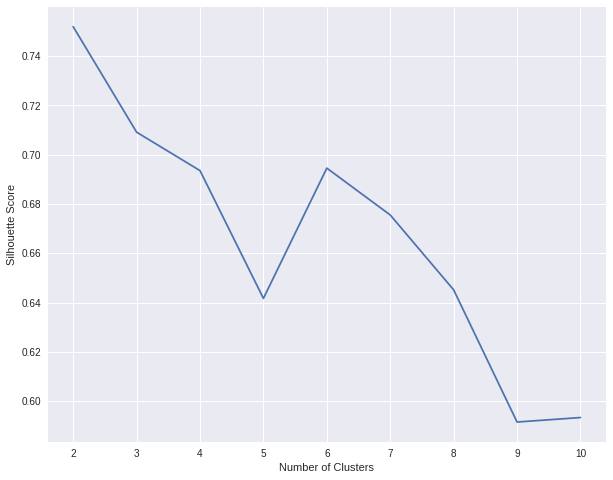

In [ ]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1,1, figsize =(10,8))
ax.plot(range(2,11),silhouette_scores)
ax.set_xlabel('Number of Clusters')
ax.set_ylabel('Silhouette Score')

In [ ]:
KMeans_=KMeans(featuresCol='target', k=2) 
KMeans_Model=KMeans_.fit(assembled_data)
KMeans_Assignments=KMeans_Model.transform(assembled_data)

In [ ]:
from pyspark.ml.feature import PCA as PCAml
pca = PCAml(k=2, inputCol="target", outputCol="pca")
pca_model = pca.fit(assembled_data)
pca_transformed = pca_model.transform(assembled_data)

In [ ]:
import numpy as np
x_pca = np.array(pca_transformed.rdd.map(lambda row: row.pca).collect())

In [ ]:
cluster_assignment = np.array(KMeans_Assignments.rdd.map(lambda row: row.prediction).collect()).reshape(-1,1)

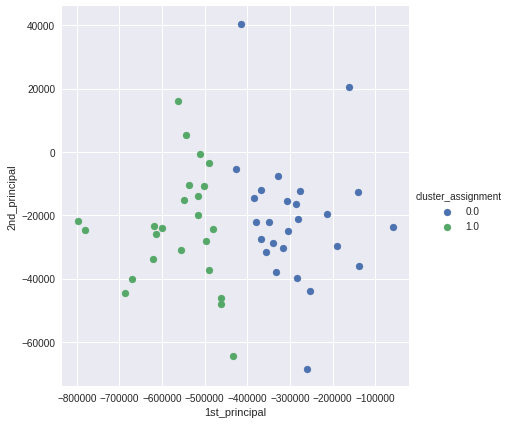

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

pca_data = np.hstack((x_pca,cluster_assignment))

pca_df = pd.DataFrame(data=pca_data, columns=("1st_principal", "2nd_principal","cluster_assignment"))
sns.FacetGrid(pca_df,hue="cluster_assignment", height=6).map(plt.scatter, '1st_principal', '2nd_principal' ).add_legend()

plt.show()

In [ ]:
KMeans_Assignments.groupBy('prediction').count().show()

+----------+-----+
|prediction|count|
+----------+-----+
|         1|   24|
|         0|   26|
+----------+-----+



In [ ]:
class_pred = KMeans_Assignments.groupBy('prediction')

In [ ]:
KMeans_Assignments.show()

+------------------+--------------+-------------------+----------+---------+------------------+--------------------+----------+
|AdvertisementSpend|PromotionSpend|AdministrationSpend|     State|   Profit|     TotalSpending|              target|prediction|
+------------------+--------------+-------------------+----------+---------+------------------+--------------------+----------+
|          165349.2|      136897.8|           471784.1|  New York|192261.83|          774031.1|[192261.83,774031.1]|         1|
|          162597.7|     151377.59|          443898.53|California|191792.06| 757873.8200000001|[191792.06,757873...|         1|
|         153441.51|     101145.55|          407934.54|   Florida|191050.39|          662521.6|[191050.39,662521.6]|         1|
|         144372.41|     118671.85|          383199.62|  New York|182901.99|         646243.88|[182901.99,646243...|         1|
|         142107.34|      91391.77|          366168.42|   Florida|166187.94|         599667.53|[166187.9

In [ ]:
df_pandas = KMeans_Assignments.toPandas()
# Importing Pandas to create DataFrame
import pandas as pd

# Creating Empty DataFrame and Storing it in variable df
df_pandas_new = pd.DataFrame(df_pandas)
df_pandas_new.head(2)

,AdvertisementSpend,PromotionSpend,AdministrationSpend,State,Profit,TotalSpending,target,prediction
0,165349.2,136897.80,471784.10,New York,192261.83,774031.10,"[192261.83, 774031.1]",1
1,162597.7,151377.59,443898.53,California,191792.06,757873.82,"[191792.06, 757873.8200000001]",1


In [ ]:
for i in range(2):
  a = df_pandas_new[df_pandas_new['prediction']==i]['Profit'].mean()
  b = df_pandas_new[df_pandas_new['prediction']==i]['TotalSpending'].mean()
  
  print(f'Cluster ke-{i}')
  print('Rata-rata Profit            : ', a)
  print('Persenan Profit             : ', ((a/(a+b))*100),'%')
  print('Rata-rata Total Pengeluaran : ', b)
  print('Persenan Spending           : ', ((b/(a+b))*100),'%')
  print()

Cluster ke-0
Rata-rata Profit            :  82549.7723076923
Persenan Profit             :  22.874791286670717 %
Rata-rata Total Pengeluaran :  278326.84192307695
Persenan Spending           :  77.12520871332929 %

Cluster ke-1
Rata-rata Profit            :  143930.745
Persenan Profit             :  20.906988589466856 %
Rata-rata Total Pengeluaran :  544502.9066666666
Persenan Spending           :  79.09301141053314 %



In [ ]:
pred_0 = df_pandas_new[df_pandas_new['prediction']==0]
pred_1 = df_pandas_new[df_pandas_new['prediction']==1]

print("Penyebaran Kota untuk Cluster 0")
print(pred_0['State'].value_counts())
print()

print("Penyebaran Kota untuk Cluster 1")
print(pred_1['State'].value_counts())
print()

Penyebaran Kota untuk Cluster 0
California    10
New York       9
Florida        7
Name: State, dtype: int64

Penyebaran Kota untuk Cluster 1
Florida       9
New York      8
California    7
Name: State, dtype: int64



### **2. Clustering (Jumlah n dari Inputan Penulis)**

In [ ]:
KMeans_=KMeans(featuresCol='target', k=5) 
KMeans_Model=KMeans_.fit(assembled_data)
KMeans_Assignments=KMeans_Model.transform(assembled_data)

In [ ]:
from pyspark.ml.feature import PCA as PCAml
pca = PCAml(k=2, inputCol="target", outputCol="pca")
pca_model = pca.fit(assembled_data)
pca_transformed = pca_model.transform(assembled_data)

In [ ]:
import numpy as np
x_pca = np.array(pca_transformed.rdd.map(lambda row: row.pca).collect())

In [ ]:
cluster_assignment = np.array(KMeans_Assignments.rdd.map(lambda row: row.prediction).collect()).reshape(-1,1)

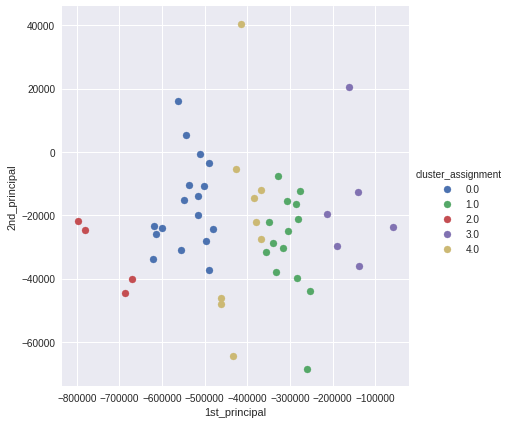

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

pca_data = np.hstack((x_pca,cluster_assignment))

pca_df = pd.DataFrame(data=pca_data, columns=("1st_principal", "2nd_principal","cluster_assignment"))
sns.FacetGrid(pca_df,hue="cluster_assignment", height=6).map(plt.scatter, '1st_principal', '2nd_principal' ).add_legend()

plt.show()

In [ ]:
KMeans_Assignments.groupBy('prediction').count().show()

+----------+-----+
|prediction|count|
+----------+-----+
|         1|   14|
|         3|    6|
|         4|    9|
|         2|    4|
|         0|   17|
+----------+-----+



In [ ]:
class_pred = KMeans_Assignments.groupBy('prediction')

In [ ]:
KMeans_Assignments.show()

+------------------+--------------+-------------------+----------+---------+------------------+--------------------+----------+
|AdvertisementSpend|PromotionSpend|AdministrationSpend|     State|   Profit|     TotalSpending|              target|prediction|
+------------------+--------------+-------------------+----------+---------+------------------+--------------------+----------+
|          165349.2|      136897.8|           471784.1|  New York|192261.83|          774031.1|[192261.83,774031.1]|         2|
|          162597.7|     151377.59|          443898.53|California|191792.06| 757873.8200000001|[191792.06,757873...|         2|
|         153441.51|     101145.55|          407934.54|   Florida|191050.39|          662521.6|[191050.39,662521.6]|         2|
|         144372.41|     118671.85|          383199.62|  New York|182901.99|         646243.88|[182901.99,646243...|         2|
|         142107.34|      91391.77|          366168.42|   Florida|166187.94|         599667.53|[166187.9

In [ ]:
df_pandas = KMeans_Assignments.toPandas()
# Importing Pandas to create DataFrame
import pandas as pd

# Creating Empty DataFrame and Storing it in variable df
df_pandas_new = pd.DataFrame(df_pandas)
df_pandas_new.head(2)

,AdvertisementSpend,PromotionSpend,AdministrationSpend,State,Profit,TotalSpending,target,prediction
0,165349.2,136897.80,471784.10,New York,192261.83,774031.10,"[192261.83, 774031.1]",2
1,162597.7,151377.59,443898.53,California,191792.06,757873.82,"[191792.06, 757873.8200000001]",2


In [ ]:
for i in range(5):
  a = df_pandas_new[df_pandas_new['prediction']==i]['Profit'].mean()
  b = df_pandas_new[df_pandas_new['prediction']==i]['TotalSpending'].mean()
  
  print(f'Cluster ke-{i}')
  print('Rata-rata Profit         :', a)
  print('Persenan Profit          :', ((a/(a+b))*100),'%')
  print('Rata-rata Total Spending :', b)
  print('Persenan Spending        :', ((b/(a+b))*100),'%')
  print('Modal                    :', a+b)
  print()

Cluster ke-0
Rata-rata Profit         : 132342.8088235294
Persenan Profit          : 20.116808113706615 %
Rata-rata Total Spending : 525528.9970588235
Persenan Spending        : 79.88319188629337 %
Modal                    : 657871.8058823529

Cluster ke-1
Rata-rata Profit         : 93627.68357142857
Persenan Profit          : 24.242143022066077 %
Rata-rata Total Spending : 292590.99142857146
Persenan Spending        : 75.75785697793393 %
Modal                    : 386218.67500000005

Cluster ke-2
Rata-rata Profit         : 189501.5675
Persenan Profit          : 21.06347247917663 %
Rata-rata Total Spending : 710167.6
Persenan Spending        : 78.93652752082338 %
Modal                    : 899669.1675

Cluster ke-3
Rata-rata Profit         : 48799.98833333334
Persenan Profit          : 25.3843372065177 %
Rata-rata Total Spending : 143444.49666666667
Persenan Spending        : 74.6156627934823 %
Modal                    : 192244.48500000002

Cluster ke-4
Rata-rata Profit         : 10991

In [ ]:
pred_0 = df_pandas_new[df_pandas_new['prediction']==0]
pred_1 = df_pandas_new[df_pandas_new['prediction']==1]
pred_2 = df_pandas_new[df_pandas_new['prediction']==2]
pred_3 = df_pandas_new[df_pandas_new['prediction']==3]
pred_4 = df_pandas_new[df_pandas_new['prediction']==4]

print("Penyebaran Kota untuk Cluster 0")
print(pred_0['State'].value_counts())
print()

print("Penyebaran Kota untuk Cluster 1")
print(pred_1['State'].value_counts())
print()

print("Penyebaran Kota untuk Cluster 2")
print(pred_2['State'].value_counts())
print()

print("Penyebaran Kota untuk Cluster 3")
print(pred_3['State'].value_counts())
print()

print("Penyebaran Kota untuk Cluster 4")
print(pred_4['State'].value_counts())
print()

Penyebaran Kota untuk Cluster 0
Florida       7
New York      6
California    4
Name: State, dtype: int64

Penyebaran Kota untuk Cluster 1
New York      6
California    6
Florida       2
Name: State, dtype: int64

Penyebaran Kota untuk Cluster 2
New York      2
California    1
Florida       1
Name: State, dtype: int64

Penyebaran Kota untuk Cluster 3
New York      3
California    3
Name: State, dtype: int64

Penyebaran Kota untuk Cluster 4
Florida       6
California    3
Name: State, dtype: int64



## **Ads Optimization**

### **Load Dataset**

In [ ]:
df_ads.show(2,False)

+----+----+----+----+----+----+----+----+----+-----+
|Ad 1|Ad 2|Ad 3|Ad 4|Ad 5|Ad 6|Ad 7|Ad 8|Ad 9|Ad 10|
+----+----+----+----+----+----+----+----+----+-----+
|1   |0   |0   |0   |1   |0   |0   |0   |1   |0    |
|0   |0   |0   |0   |0   |0   |0   |0   |1   |0    |
+----+----+----+----+----+----+----+----+----+-----+
only showing top 2 rows



In [ ]:
df_ads_pandas = df_ads.toPandas()
df_ads_pandas.head()

,Ad 1,Ad 2,Ad 3,Ad 4,Ad 5,Ad 6,Ad 7,Ad 8,Ad 9,Ad 10
0,1,0,0,0,1,0,0,0,1,0
1,0,0,0,0,0,0,0,0,1,0
2,0,0,0,0,0,0,0,0,0,0
3,0,1,0,0,0,0,0,1,0,0
4,0,0,0,0,0,0,0,0,0,0


In [ ]:
print("Jumlah data sebelum drop null:", df_ads.count())
df_ads = df_ads.na.drop("any")
print("Jumlah data setelah drop null : ",df_ads.count())

Jumlah data sebelum drop null: 10000
Jumlah data setelah drop null :  10000


In [ ]:
df_ads_pandas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   Ad 1    10000 non-null  int32
 1   Ad 2    10000 non-null  int32
 2   Ad 3    10000 non-null  int32
 3   Ad 4    10000 non-null  int32
 4   Ad 5    10000 non-null  int32
 5   Ad 6    10000 non-null  int32
 6   Ad 7    10000 non-null  int32
 7   Ad 8    10000 non-null  int32
 8   Ad 9    10000 non-null  int32
 9   Ad 10   10000 non-null  int32
dtypes: int32(10)
memory usage: 390.8 KB


### **EDA**

In [ ]:
click_rate = []
for i in range(10):
  print()
  print(df_ads_pandas.columns[i])
  print(df_ads_pandas[df_ads_pandas.columns[i]].value_counts())
  click_rate.append(df_ads_pandas[df_ads_pandas.columns[i]].value_counts()[1])


Ad 1
0    8297
1    1703
Name: Ad 1, dtype: int64

Ad 2
0    8705
1    1295
Name: Ad 2, dtype: int64

Ad 3
0    9272
1     728
Name: Ad 3, dtype: int64

Ad 4
0    8804
1    1196
Name: Ad 4, dtype: int64

Ad 5
0    7305
1    2695
Name: Ad 5, dtype: int64

Ad 6
0    9874
1     126
Name: Ad 6, dtype: int64

Ad 7
0    8888
1    1112
Name: Ad 7, dtype: int64

Ad 8
0    7909
1    2091
Name: Ad 8, dtype: int64

Ad 9
0    9048
1     952
Name: Ad 9, dtype: int64

Ad 10
0    9511
1     489
Name: Ad 10, dtype: int64


In [ ]:
print(click_rate)
print('Rata-rata Click rate : ', np.mean(click_rate))
print('Max Click rate : ', np.max(click_rate))
print('Min Click rate : ', np.min(click_rate))

[1703, 1295, 728, 1196, 2695, 126, 1112, 2091, 952, 489]
Rata-rata Click rate :  1238.7
Max Click rate :  2695
Min Click rate :  126


## **Market Basket Optimization**

### **Load Dataset**

In [ ]:
df_marketbasket.show(2,False)

+-------+---------+-------+--------------+------------+----------------+----+--------------+------------+------------+--------------+---------+-----+-----+-------------+------+-----------------+---------------+-------+---------+
|col1   |col2     |col3   |col4          |col5        |col6            |col7|col8          |col9        |col10       |col11         |col12    |col13|col14|col15        |col16 |col17            |col18          |col19  |col20    |
+-------+---------+-------+--------------+------------+----------------+----+--------------+------------+------------+--------------+---------+-----+-----+-------------+------+-----------------+---------------+-------+---------+
|shrimp |almonds  |avocado|vegetables mix|green grapes|whole weat flour|yams|cottage cheese|energy drink|tomato juice|low fat yogurt|green tea|honey|salad|mineral water|salmon|antioxydant juice|frozen smoothie|spinach|olive oil|
|burgers|meatballs|eggs   |null          |null        |null            |null|null   

### **EDA**

In [ ]:
df_basket_pandas = df_marketbasket.toPandas()
df_basket_pandas.fillna("-", inplace = True)

In [ ]:
df_basket_pandas

,col1,col2,col3,col4,col5,col6,col7,col8,col9,col10,col11,col12,col13,col14,col15,col16,col17,col18,col19,col20
0,shrimp,almonds,avocado,vegetables mix,green grapes,whole weat flour,yams,cottage cheese,energy drink,tomato juice,low fat yogurt,green tea,honey,salad,mineral water,salmon,antioxydant juice,frozen smoothie,spinach,olive oil
1,burgers,meatballs,eggs,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-
2,chutney,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-
3,turkey,avocado,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-
4,mineral water,milk,energy bar,whole wheat rice,green tea,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7496,butter,light mayo,fresh bread,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-
7497,burgers,frozen vegetables,eggs,french fries,magazines,green tea,-,-,-,-,-,-,-,-,-,-,-,-,-,-
7498,chicken,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-
7499,escalope,green tea,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-


In [ ]:
arr_item = {}
for i in range(20):
  print()
  print(df_basket_pandas.columns[i])
  print(df_basket_pandas[df_basket_pandas.columns[i]].value_counts())
  arr_item['col_{}'.format(i)] = df_basket_pandas[df_basket_pandas.columns[i]].value_counts()


col1
mineral water        577
burgers              576
turkey               458
chocolate            391
frozen vegetables    373
                    ... 
cauliflower            1
ketchup                1
cream                  1
body spray             1
oatmeal                1
Name: col1, Length: 115, dtype: int64

col2
-                1754
mineral water     484
spaghetti         411
eggs              302
ground beef       291
                 ... 
asparagus           2
chili               1
water spray         1
cream               1
cauliflower         1
Name: col2, Length: 118, dtype: int64

col3
-                   3112
mineral water        375
spaghetti            279
eggs                 225
milk                 213
                    ... 
pickles                1
cream                  1
water spray            1
hand protein bar       1
cauliflower            1
Name: col3, Length: 116, dtype: int64

col4
-                4156
mineral water     201
eggs              181
fren

In [ ]:
list_basket = pd.DataFrame(arr_item)
list_basket.fillna(0, inplace = True)
update_df_basket = list_basket.drop('-')
update_df_basket.head(5)

,col_0,col_1,col_2,col_3,col_4,col_5,col_6,col_7,col_8,col_9,col_10,col_11,col_12,col_13,col_14,col_15,col_16,col_17,col_18,col_19
asparagus,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
almonds,11.0,29.0,35.0,29.0,12.0,13.0,10.0,7.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
antioxydant juice,18.0,10.0,12.0,6.0,3.0,6.0,2.0,7.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
asparagus,3.0,2.0,5.0,4.0,4.0,3.0,2.0,7.0,2.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
avocado,57.0,64.0,46.0,43.0,18.0,9.0,7.0,5.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
sum_column = update_df_basket.sum(axis=1)
sum_itembasket = pd.DataFrame(sum_column)
sum_itembasket.rename(columns={'index': "Nama Item", 0: "Total Item"}, inplace=True)
sum_itembasket.drop(' asparagus', inplace=True)
sum_itembasket.head()

,Total Item
almonds,153.0
antioxydant juice,67.0
asparagus,35.0
avocado,250.0
babies food,34.0


In [ ]:
sum_itembasket.sort_values(by=['Total Item'],ascending=False)

,Total Item
mineral water,1788.0
eggs,1348.0
spaghetti,1306.0
french fries,1282.0
chocolate,1230.0
...,...
tea,29.0
bramble,14.0
cream,7.0
napkins,5.0


In [ ]:
sum_itembasket.shape

(119, 1)

## **Supermarket Customer Member**

### **Load Dataset**

In [ ]:
df_custmember.show(2,False)

+----------+-----+---+------------------+----------------------+
|CustomerID|Genre|Age|Annual Income (k$)|Spending Score (1-100)|
+----------+-----+---+------------------+----------------------+
|1         |Male |19 |15                |39                    |
|2         |Male |21 |15                |81                    |
+----------+-----+---+------------------+----------------------+
only showing top 2 rows



In [ ]:
df_member_pandas = df_custmember.toPandas()

In [ ]:
df_member_pandas[df_member_pandas.columns[1]].value_counts()

Female    112
Male       88
Name: Genre, dtype: int64

In [ ]:
df_member_pandas.describe()

,CustomerID,Age,Annual Income (k$),Spending Score (1-100)
count,200.000000,200.000000,200.000000,200.000000
mean,100.500000,38.850000,60.560000,50.200000
std,57.879185,13.969007,26.264721,25.823522
min,1.000000,18.000000,15.000000,1.000000
25%,50.750000,28.750000,41.500000,34.750000
50%,100.500000,36.000000,61.500000,50.000000
75%,150.250000,49.000000,78.000000,73.000000
max,200.000000,70.000000,137.000000,99.000000


### **Data Preprocessing**

In [ ]:
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType

In [ ]:
def range_age(Age):
  if(Age < 25) :
    return "Gen Z"
  elif (Age >= 25 and Age <= 40):
    return 'Gen Y'
  elif (Age > 40 and Age <= 56):
    return 'Gen X'
  elif (Age > 56):
    return 'Baby Boomers'
  else :
    return 'No Definition'

In [ ]:
age = udf(range_age)
df_member = df_custmember.withColumn('Age_udf', age('Age'))
df_member.show(5, False)

+----------+------+---+------------------+----------------------+-------+
|CustomerID|Genre |Age|Annual Income (k$)|Spending Score (1-100)|Age_udf|
+----------+------+---+------------------+----------------------+-------+
|1         |Male  |19 |15                |39                    |Gen Z  |
|2         |Male  |21 |15                |81                    |Gen Z  |
|3         |Female|20 |16                |6                     |Gen Z  |
|4         |Female|23 |16                |77                    |Gen Z  |
|5         |Female|31 |17                |40                    |Gen Y  |
+----------+------+---+------------------+----------------------+-------+
only showing top 5 rows



### **OneHot Encoder**

In [ ]:
from pyspark.ml.feature import StringIndexer

indexer = StringIndexer(inputCol='Age_udf', outputCol='Age_ohe')
indexer_fitted = indexer.fit(df_member)
df_member= indexer_fitted.transform(df_member)
df_member.show(2)

+----------+-----+---+------------------+----------------------+-------+-------+
|CustomerID|Genre|Age|Annual Income (k$)|Spending Score (1-100)|Age_udf|Age_ohe|
+----------+-----+---+------------------+----------------------+-------+-------+
|         1| Male| 19|                15|                    39|  Gen Z|    2.0|
|         2| Male| 21|                15|                    81|  Gen Z|    2.0|
+----------+-----+---+------------------+----------------------+-------+-------+
only showing top 2 rows



In [ ]:
indexer = StringIndexer(inputCol='Genre', outputCol='Genre_ohe')
indexer_fitted = indexer.fit(df_member)
df_member= indexer_fitted.transform(df_member)
df_member.show(2)

+----------+-----+---+------------------+----------------------+-------+-------+---------+
|CustomerID|Genre|Age|Annual Income (k$)|Spending Score (1-100)|Age_udf|Age_ohe|Genre_ohe|
+----------+-----+---+------------------+----------------------+-------+-------+---------+
|         1| Male| 19|                15|                    39|  Gen Z|    2.0|      1.0|
|         2| Male| 21|                15|                    81|  Gen Z|    2.0|      1.0|
+----------+-----+---+------------------+----------------------+-------+-------+---------+
only showing top 2 rows



### **Vector Assembler for Clustering**

In [ ]:
sel_col = ['Annual Income (k$)',	'Spending Score (1-100)', 'Age_ohe', 'Genre_ohe']
assemble_cust = VectorAssembler(inputCols=sel_col, outputCol = 'target_cust')
assembled_member = assemble_cust.transform(df_member)

### **1. Clustering with Method Elbow**

In [ ]:
eval_cust = ClusteringEvaluator(predictionCol='prediction', 
                           featuresCol='target_cust',
                           metricName='silhouette', 
                           distanceMeasure='squaredEuclidean')

In [ ]:
silhouette_scores = []
for K in range(2,11):

    KMeans_algo = KMeans(featuresCol='target_cust', k=K)
    KMeans_fit  = KMeans_algo.fit(assembled_member)
    output      = KMeans_fit.transform(assembled_member) 
    score       = eval_cust.evaluate(output)
    silhouette_scores.append(score)
    print(f"K{K}\t{score}\t")

K2	0.5414093620212836	
K3	0.43443760943283816	
K4	0.6620657096239553	
K5	0.6336977075282921	
K6	0.7273870071033686	
K7	0.6512295184036536	
K8	0.6735819660257983	
K9	0.6699345820703673	
K10	0.6120825326373448	


Text(0, 0.5, 'Silhouette Score')

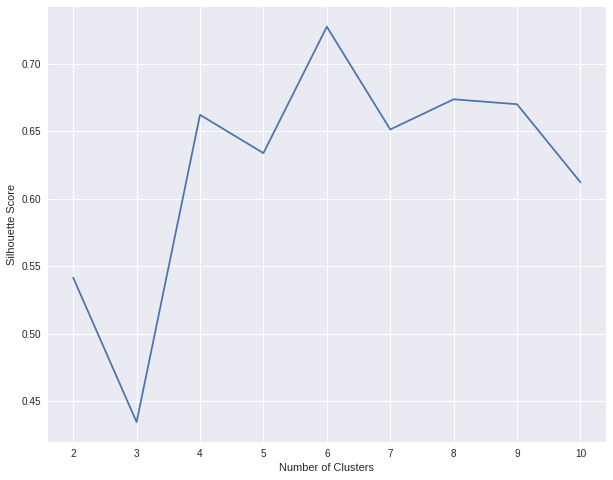

In [ ]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1,1, figsize =(10,8))
ax.plot(range(2,11),silhouette_scores)
ax.set_xlabel('Number of Clusters')
ax.set_ylabel('Silhouette Score')

In [ ]:
KMeans_algorithm=KMeans(featuresCol='target_cust', k=6) 
Model=KMeans_algorithm.fit(assembled_member)
KMeans_Assignments=Model.transform(assembled_member)

In [ ]:
from pyspark.ml.feature import PCA as PCAml
pca = PCAml(k=2, inputCol="target_cust", outputCol="pca")
pca_model = pca.fit(assembled_member)
pca_transformed = pca_model.transform(assembled_member)

In [ ]:
import numpy as np
x_pca = np.array(pca_transformed.rdd.map(lambda row: row.pca).collect())

cluster_assignment = np.array(KMeans_Assignments.rdd.map(lambda row: row.prediction).collect()).reshape(-1,1)

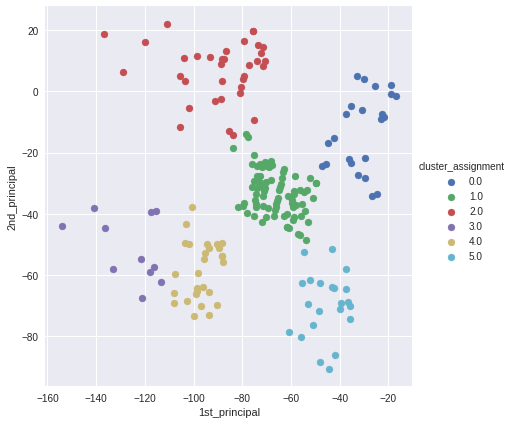

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

pca_data = np.hstack((x_pca,cluster_assignment))

pca_df = pd.DataFrame(data=pca_data, columns=("1st_principal", "2nd_principal","cluster_assignment"))
sns.FacetGrid(pca_df,hue="cluster_assignment", height=6).map(plt.scatter, '1st_principal', '2nd_principal' ).add_legend()

plt.show()

In [ ]:
KMeans_Assignments.groupBy('prediction').count().show()

+----------+-----+
|prediction|count|
+----------+-----+
|         1|   81|
|         3|   11|
|         5|   22|
|         4|   28|
|         2|   35|
|         0|   23|
+----------+-----+



In [ ]:
class_pred = KMeans_Assignments.groupBy('prediction')

KMeans_Assignments.show()

+----------+------+---+------------------+----------------------+------------+-------+---------+-------------------+----------+
|CustomerID| Genre|Age|Annual Income (k$)|Spending Score (1-100)|     Age_udf|Age_ohe|Genre_ohe|        target_cust|prediction|
+----------+------+---+------------------+----------------------+------------+-------+---------+-------------------+----------+
|         1|  Male| 19|                15|                    39|       Gen Z|    2.0|      1.0|[15.0,39.0,2.0,1.0]|         0|
|         2|  Male| 21|                15|                    81|       Gen Z|    2.0|      1.0|[15.0,81.0,2.0,1.0]|         5|
|         3|Female| 20|                16|                     6|       Gen Z|    2.0|      0.0| [16.0,6.0,2.0,0.0]|         0|
|         4|Female| 23|                16|                    77|       Gen Z|    2.0|      0.0|[16.0,77.0,2.0,0.0]|         5|
|         5|Female| 31|                17|                    40|       Gen Y|    0.0|      0.0|[17.0,40

In [ ]:
df_pandas = KMeans_Assignments.toPandas()
# Importing Pandas to create DataFrame
import pandas as pd

# Creating Empty DataFrame and Storing it in variable df
df_pandas_new = pd.DataFrame(df_pandas)
df_pandas_new.head(2)

,CustomerID,Genre,Age,Annual Income (k$),Spending Score (1-100),Age_udf,Age_ohe,Genre_ohe,target_cust,prediction
0,1,Male,19,15,39,Gen Z,2.0,1.0,"[15.0, 39.0, 2.0, 1.0]",0
1,2,Male,21,15,81,Gen Z,2.0,1.0,"[15.0, 81.0, 2.0, 1.0]",5


In [ ]:
pred_0 = df_pandas_new[df_pandas_new['prediction']==0]
pred_1 = df_pandas_new[df_pandas_new['prediction']==1]
pred_2 = df_pandas_new[df_pandas_new['prediction']==2]
pred_3 = df_pandas_new[df_pandas_new['prediction']==3]
pred_4 = df_pandas_new[df_pandas_new['prediction']==4]
pred_5 = df_pandas_new[df_pandas_new['prediction']==5]

print("Penyebaran Genre untuk Cluster 0")
print(pred_0['Genre'].value_counts())
print()

print("Penyebaran Genre untuk Cluster 1")
print(pred_1['Genre'].value_counts())
print()

print("Penyebaran Genre untuk Cluster 2")
print(pred_2['Genre'].value_counts())
print()

print("Penyebaran Genre untuk Cluster 3")
print(pred_3['Genre'].value_counts())
print()

print("Penyebaran Genre untuk Cluster 4")
print(pred_4['Genre'].value_counts())
print()

print("Penyebaran Genre untuk Cluster 5")
print(pred_5['Genre'].value_counts())
print()

Penyebaran Genre untuk Cluster 0
Female    14
Male       9
Name: Genre, dtype: int64

Penyebaran Genre untuk Cluster 1
Female    48
Male      33
Name: Genre, dtype: int64

Penyebaran Genre untuk Cluster 2
Male      19
Female    16
Name: Genre, dtype: int64

Penyebaran Genre untuk Cluster 3
Female    6
Male      5
Name: Genre, dtype: int64

Penyebaran Genre untuk Cluster 4
Female    15
Male      13
Name: Genre, dtype: int64

Penyebaran Genre untuk Cluster 5
Female    13
Male       9
Name: Genre, dtype: int64



In [ ]:
for i in range(6):
  print(f'Cluster ke-{i}')
  print('Rata-rata Annual Income (k$)  : ', df_pandas_new[df_pandas_new['prediction']==i]['Annual Income (k$)'].mean())
  print('Rata-rata Spending Score (1-100) : ', df_pandas_new[df_pandas_new['prediction']==i]['Spending Score (1-100)'].mean())
  print('Rata-rata Age  : ', df_pandas_new[df_pandas_new['prediction']==i]['Age'].mean())
  print('Rata-rata Gender : ', df_pandas_new[df_pandas_new['prediction']==i]['Genre_ohe'].mean())
  print()

Cluster ke-0
Rata-rata Annual Income (k$)  :  26.304347826086957
Rata-rata Spending Score (1-100) :  20.91304347826087
Rata-rata Age  :  45.21739130434783
Rata-rata Gender :  0.391304347826087

Cluster ke-1
Rata-rata Annual Income (k$)  :  55.2962962962963
Rata-rata Spending Score (1-100) :  49.51851851851852
Rata-rata Age  :  42.71604938271605
Rata-rata Gender :  0.4074074074074074

Cluster ke-2
Rata-rata Annual Income (k$)  :  88.2
Rata-rata Spending Score (1-100) :  17.114285714285714
Rata-rata Age  :  41.114285714285714
Rata-rata Gender :  0.5428571428571428

Cluster ke-3
Rata-rata Annual Income (k$)  :  108.18181818181819
Rata-rata Spending Score (1-100) :  82.72727272727273
Rata-rata Age  :  32.45454545454545
Rata-rata Gender :  0.45454545454545453

Cluster ke-4
Rata-rata Annual Income (k$)  :  78.03571428571429
Rata-rata Spending Score (1-100) :  81.89285714285714
Rata-rata Age  :  32.785714285714285
Rata-rata Gender :  0.4642857142857143

Cluster ke-5
Rata-rata Annual Income (k

### **Vector Assembler for Regression**

In [ ]:
sel_col = ['Annual Income (k$)', 'Spending Score (1-100)','Genre_ohe']
assemble_reg = VectorAssembler(inputCols=sel_col, outputCol = 'target_reg')
assembled_member_reg = assemble_reg.transform(df_member)

In [ ]:
finalised_data = assembled_member_reg.select('target_reg', 'Age_ohe')
finalised_data.show()

+---------------+-------+
|     target_reg|Age_ohe|
+---------------+-------+
|[15.0,39.0,1.0]|    2.0|
|[15.0,81.0,1.0]|    2.0|
| [16.0,6.0,0.0]|    2.0|
|[16.0,77.0,0.0]|    2.0|
|[17.0,40.0,0.0]|    0.0|
|[17.0,76.0,0.0]|    2.0|
| [18.0,6.0,0.0]|    0.0|
|[18.0,94.0,0.0]|    2.0|
| [19.0,3.0,1.0]|    3.0|
|[19.0,72.0,0.0]|    0.0|
|[19.0,14.0,1.0]|    3.0|
|[19.0,99.0,0.0]|    0.0|
|[20.0,15.0,0.0]|    3.0|
|[20.0,77.0,0.0]|    2.0|
|[20.0,13.0,1.0]|    0.0|
|[20.0,79.0,1.0]|    2.0|
|[21.0,35.0,0.0]|    0.0|
|[21.0,66.0,1.0]|    2.0|
|[23.0,29.0,1.0]|    1.0|
|[23.0,98.0,0.0]|    0.0|
+---------------+-------+
only showing top 20 rows



In [ ]:
train, test = finalised_data.randomSplit([0.7, 0.3])

### **2. Linear Regression**

In [ ]:
from pyspark.ml.regression import LinearRegression

lr = LinearRegression(featuresCol = 'target_reg', labelCol="Age_ohe")
lrn = lr.fit(train)

In [ ]:
#make predictions on the test set
predictions = lrn.transform(test)

# show the predicted values and the actual values
predictions.select('prediction' ,'Age_ohe').show(10)

+------------------+-------+
|        prediction|Age_ohe|
+------------------+-------+
|  1.43103257176765|    0.0|
| 1.061012495864306|    2.0|
|1.7705025706686652|    0.0|
|1.9036459449980372|    3.0|
|1.6580107394552095|    3.0|
|1.3491856897889205|    2.0|
|1.8965018321087248|    3.0|
|1.5383747953524414|    1.0|
|0.9620280948774542|    2.0|
|1.3750611455760875|    0.0|
+------------------+-------+
only showing top 10 rows



In [ ]:
from pyspark.ml.evaluation import RegressionEvaluator
#RMSE on test set
evaluator = RegressionEvaluator(predictionCol='prediction', 
                                labelCol='Age_ohe', metricName='rmse')
rmse_test = evaluator.evaluate(predictions)
print('RMSE on test set: ', rmse_test)

RMSE on test set:  1.0047258773637804


### **3. Decision Tree Regression**

In [ ]:
from pyspark.ml.regression import DecisionTreeRegressor

tree = DecisionTreeRegressor(featuresCol = 'target_reg', labelCol="Age_ohe")
dec3 = tree.fit(train)

In [ ]:
#make predictions on the test set
predictions_dec3 = dec3.transform(test)

# show the predicted values and the actual values
predictions_dec3.select('prediction' ,'Age_ohe').show(10)

+------------------+-------+
|        prediction|Age_ohe|
+------------------+-------+
|               2.0|    0.0|
|               2.0|    2.0|
|               2.0|    0.0|
|              0.52|    3.0|
|              0.52|    3.0|
|              0.52|    2.0|
|               2.0|    3.0|
|              0.52|    1.0|
|1.7142857142857142|    2.0|
|              0.52|    0.0|
+------------------+-------+
only showing top 10 rows



In [ ]:
from pyspark.ml.evaluation import RegressionEvaluator
#RMSE on test set
dt_evaluator = RegressionEvaluator(predictionCol='prediction', 
                                labelCol='Age_ohe', metricName='rmse')
rmse_test = dt_evaluator.evaluate(predictions_dec3)
print('RMSE on test set: ', rmse_test)

RMSE on test set:  1.2338008234635234


In [ ]:
dec3.featureImportances

SparseVector(3, {0: 0.5993, 1: 0.3855, 2: 0.0152})

### **4. Gradient-boosted Tree Regression**

In [ ]:
from pyspark.ml.regression import GBTRegressor

gr = GBTRegressor(featuresCol = 'target_reg', labelCol="Age_ohe")
grad = gr.fit(train)

In [ ]:
#make predictions on the test set
predictions_grad = grad.transform(test)

# show the predicted values and the actual values
predictions_grad.select('prediction' ,'Age_ohe').show(10)

+--------------------+-------+
|          prediction|Age_ohe|
+--------------------+-------+
|-0.05253252316687164|    0.0|
|  1.7945416458383812|    0.0|
|   3.226201296365298|    0.0|
|  0.5180863018403175|    0.0|
|  0.6302638844651157|    0.0|
|   1.032731007191332|    1.0|
|  0.7637786576729885|    0.0|
|  1.7383259098083719|    2.0|
|  0.8918774026064828|    1.0|
|  1.5509069830566353|    2.0|
+--------------------+-------+
only showing top 10 rows



In [ ]:
from pyspark.ml.evaluation import RegressionEvaluator
#RMSE on test set
gbt_evaluator = RegressionEvaluator(predictionCol='prediction', 
                                labelCol='Age_ohe', metricName='rmse')
rmse_test = gbt_evaluator.evaluate(predictions_grad)
print('RMSE on test set: ', rmse_test)

RMSE on test set:  1.1285804415116063
